<a href="https://colab.research.google.com/github/petergchang/sarkka-jax/blob/main/Ch4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4. Bayesian Filtering Equations and Exact Solutions

This notebook replicates the figures of Chapter 4 of  Särkkä's "Bayesian Filtering and Smoothing" using JAX.

Simo Särkkä (2013), “Bayesian Filtering and Smoothing,” Cambridge University Press. Available: https://users.aalto.fi/~ssarkka/pub/cup_book_online_20131111.pdf

This JAX translation is by Peter G. Chang ([@petergchang](https://github.com/petergchang))



## 4.0 Imports

In [2]:
%matplotlib inline

import jax
import jax.numpy as jnp
import jax.random as jr
from jax import lax
import matplotlib.pyplot as plt

## 4.1 Probabilistic State Space Models

First, we generate random signal and measurements according to a Gaussian random walk to replicate Figure 4.1

In [32]:
# 1-dimensional random walk simulation
def simulate_rw_1d(init, Q, R, num_steps):
    def _step(carry, rng):
        x_prev = carry

        # Random walk and measurement
        key1, key2 = jr.split(rng)
        x_post = x_prev + jr.normal(key1)*Q
        y = x_post + jr.normal(key2)
        return x_post, (x_post, y)

    carry = init
    rngs = jr.split(jr.PRNGKey(0), num_steps)
    _, (xs, ys) = lax.scan(
        _step, carry, rngs
    )
    return xs, ys

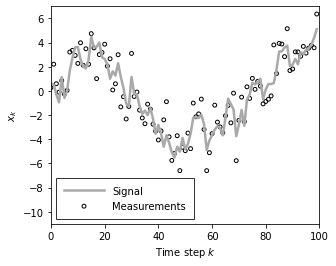

In [48]:
# Generate random walk data with num_steps=100
xs, ys = simulate_rw_1d(0, 1, 1, 100)

# Generate grid
t_grid = jnp.arange(100).reshape(-1,1)

# Plot the generated data
plt.figure()
plt.plot(t_grid, xs, color='darkgray', linewidth=2.5, label="Signal")
plt.scatter(t_grid, ys, s=15, facecolors='none', edgecolors='k', label='Measurements')
plt.xlabel('Time step $k$'); plt.ylabel('$x_k$')
plt.xlim(0, 100); plt.ylim(-11, 7)
plt.yticks(jnp.arange(-10, 7, 2))
plt.gca().set_aspect(4.5)
plt.legend(loc=3, borderpad=0.8, handlelength=4, fancybox=False, edgecolor='k');
plt.show()